# Inference

In [40]:
import time
import datetime
import os
import ast
import sys
import pytz
import random
import shutil
# import splitfolders
import copy
from glob import glob
from tqdm import tqdm
from pprint import pprint

import warnings
import requests

import gc
import math
import numpy as np
import pandas as pd

import cv2
from PIL import Image
# import pydicom as pdm
import pickle
import yaml
import h5py
import json
import matplotlib.pyplot as plt
# import seaborn as sns

import albumentations as albu
import torch
import torch.nn as nn  
# import torchtuples as tt
from sklearn import metrics

import torchvision
import timm 
# import pretrainedmodels

In [41]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else: DEVICE = torch.device('cpu')
    
print('Using PyTorchversion:', torch.__version__, 'Device:', DEVICE)

Using PyTorchversion: 1.10.0+cu113 Device: cuda


In [42]:
WORK_DIR = './'
ANNOT_DIR = '/mnt/dataset/test/annotation/'
IMG_DIR = '/ainode/dataset/test/'
RGB_DIR = '/ainode/dataset/test/rgb/'
FLOW_DIR = '/ainode/dataset/test/flow/'

## Load Data

In [43]:
case_lst = [path.split('/')[-1].split('_')[0] for path in glob(ANNOT_DIR+'/*')]
case_lst.sort()

In [44]:
json_lst = []
for case_dir in case_lst:
    for path in glob(os.path.join(ANNOT_DIR, case_dir+'/*.json')):
        with open(path, 'r') as j:
            jsn = json.loads(j.read())
            json_lst.append(jsn)
len(json_lst)

40

In [45]:
final_df = pd.DataFrame()

for case_json in json_lst:
    event_df = pd.DataFrame.from_dict(case_json['Video_Info'])
    event_df['Case'] = [case_json['Case_Info']['Case_Number'] for i in range(len(event_df))]
    final_df = pd.concat([final_df, event_df])
    
len(final_df)
final_df.head()

,File_Name,File_Extension,Frame_Rate,Frame_Count,Start,End,Bit_Rate,Width,Height,Case
0,A2020-EM-01-0005_video_01.mp4,mp4,4.995,138163,2020/08/27 23:06:00.000,2020/08/28 06:47:00.000,289000.0,640,480,A2020-EM-01-0005
0,A2020-EM-01-0006_video_01.mp4,mp4,4.995,128415,2020/04/11 22:27:30.000,2020/04/12 05:35:58.243,279000.0,640,480,A2020-EM-01-0006
0,A2020-EM-01-0020_video_01.mp4,mp4,4.995,120331,2020/12/07 22:55:00.000,2020/12/08 05:36:30.000,283000.0,640,480,A2020-EM-01-0020
0,A2020-EM-01-0028_video_01.mp4,mp4,4.995,114636,2020/06/15 21:28:00.000,2020/06/16 03:50:30.000,268000.0,640,480,A2020-EM-01-0028
0,A2020-EM-01-0081_video_01.mp4,mp4,4.995,128123,2020/05/15 22:30:00.000,2020/05/16 05:37:30.000,285000.0,640,480,A2020-EM-01-0081


In [46]:
caselst = list(dict.fromkeys(final_df['Case'].tolist()).keys())

In [47]:
# !mkdir ./test_max_images/

In [48]:
# for case in caselst:
#     fps = final_df[final_df['Case'] == case]['Frame_Rate'].tolist()[0]
# #     img_pth = f'{IMG_DIR}{imgtype[:4]}/{case}_video_01/' 
#     flow_pth = f'{IMG_DIR}flow/{case}_video_01/' 
#     rgb_pth = f'{RGB_DIR}{case}_video_01/'

# #     if 'flow' in imgtype:
# #         img_lst = glob(img_pth+f'/{imgtype}*.jpg')
# #     else:
# #         img_lst = glob(img_pth+'/img*.jpg')
# #     img_lst.sort()
#     flowx_lst = glob(flow_pth+'flow_x*.jpg')
#     flowy_lst = glob(flow_pth+'flow_y*.jpg')
#     rgb_lst = glob(rgb_pth+'img*.jpg')
#     flowx_lst.sort()
#     flowy_lst.sort()
#     rgb_lst.sort()
    
#     for epoch in tqdm(range(int(len(rgb_lst)/(fps*30)))):
#         rgb_arr_lst = [np.array(Image.open(img)) for img in rgb_lst[epoch:epoch+int(fps*30)]]
#         flowx_arr_lst = [np.array(Image.open(img)) for img in flowx_lst[epoch:epoch+int(fps*30)]]
#         flowy_arr_lst = [np.array(Image.open(img)) for img in flowy_lst[epoch:epoch+int(fps*30)]]
#         rgb_sum_lst = [np.concatenate(img_arr).sum() for img_arr in rgb_arr_lst]
#         flowx_sum_lst = [np.concatenate(img_arr).sum() for img_arr in flowx_arr_lst]
#         flowy_sum_lst = [np.concatenate(img_arr).sum() for img_arr in flowy_arr_lst]
#         rgb_rep_idx = rgb_sum_lst.index(max(rgb_sum_lst))
#         flowx_rep_idx = flowx_sum_lst.index(max(flowx_sum_lst))
#         flowy_rep_idx = flowy_sum_lst.index(max(flowy_sum_lst))
#         rgb_rep_img = rgb_arr_lst[rgb_rep_idx].astype(np.uint8)
#         rgb_rep_img = np.dot(rgb_rep_img[...,:3], [0.299, 0.587, 0.114])
#         flowx_rep_img = flowx_arr_lst[flowx_rep_idx]
#         flowy_rep_img = flowy_arr_lst[flowy_rep_idx]
#         final_img = (np.dstack((rgb_rep_img,flowx_rep_img,flowy_rep_img))*255).astype(np.uint8)
# #         print(final_img.shape)
# #         Image.fromarray(final_img).show()
# #         print(final_img.shape)
# #         imave = np.mean(images,axis=0).astype(np.uint8) # (128, 128)
# #         imave = Image.fromarray(imave)
#         with open(f'./test_max_images/{case}_{epoch+1}.npy', 'wb') as f:
#             np.save(f, final_img)

In [49]:
len(glob('./test_max_images/*.npy'))

32888

In [50]:
def frame2epoch(frameidx, fps): # image frame number (type 'int') to corresponding start epoch (type 'int')
    return int(frameidx//(30*fps)+1)

def epoch2frame(startepoch, fps): # start epoch (type 'int') to corresponding image frame start number, end number(type 'list')
    startframe = (startepoch-1)*fps*30
    return [int(startframe),int(startframe+fps*30)]

In [51]:
Epoch_Count = [frame2epoch(list(final_df['Frame_Count'])[idx], list(final_df['Frame_Rate'])[idx]) for idx in range(len(final_df))]

In [52]:
final_df['Epoch_Count'] = Epoch_Count

In [53]:
final_df.head(2)

,File_Name,File_Extension,Frame_Rate,Frame_Count,Start,End,Bit_Rate,Width,Height,Case,Epoch_Count
0,A2020-EM-01-0005_video_01.mp4,mp4,4.995,138163,2020/08/27 23:06:00.000,2020/08/28 06:47:00.000,289000.0,640,480,A2020-EM-01-0005,923
0,A2020-EM-01-0006_video_01.mp4,mp4,4.995,128415,2020/04/11 22:27:30.000,2020/04/12 05:35:58.243,279000.0,640,480,A2020-EM-01-0006,857


In [54]:
Epoch = []
Case = []
Frame_Rate = []
Frame_Count = []
Epoch_Count = []
num = len(glob('./test_max_images/*.npy'))
for idx, epoch_count in enumerate(list(final_df['Epoch_Count'])):
    Epoch += list(range(epoch_count-1))
    Case += [list(final_df['Case'])[idx] for i in range(epoch_count-1)]
    Frame_Rate += [list(final_df['Frame_Rate'])[idx] for i in range(epoch_count-1)]
    Frame_Count += [list(final_df['Frame_Count'])[idx] for i in range(epoch_count-1)]
    Epoch_Count += [list(final_df['Epoch_Count'])[idx] for i in range(epoch_count-1)]

dict = {'Case': Case, 'Epoch': Epoch, 'Epoch_Count': Epoch_Count, 'Frame_Count': Frame_Count, 'Frame_Rate': Frame_Rate} 
X = pd.DataFrame(dict)

Frames = []
for idx in range(len(X)):
    fps = np.array(X['Frame_Rate'])[idx]
    startepoch = np.array(X['Epoch'])[idx]
    Frames.append(epoch2frame(startepoch+1, fps))

X['Frame']=Frames


In [55]:
X

,Case,Epoch,Epoch_Count,Frame_Count,Frame_Rate,Frame
0,A2020-EM-01-0005,0,923,138163,4.995,"[0, 149]"
1,A2020-EM-01-0005,1,923,138163,4.995,"[149, 299]"
2,A2020-EM-01-0005,2,923,138163,4.995,"[299, 449]"
3,A2020-EM-01-0005,3,923,138163,4.995,"[449, 599]"
4,A2020-EM-01-0005,4,923,138163,4.995,"[599, 749]"
...,...,...,...,...,...,...
32883,A2021-EM-01-0163,929,935,139323,4.972,"[138569, 138718]"
32884,A2021-EM-01-0163,930,935,139323,4.972,"[138718, 138867]"
32885,A2021-EM-01-0163,931,935,139323,4.972,"[138867, 139017]"
32886,A2021-EM-01-0163,932,935,139323,4.972,"[139017, 139166]"


In [56]:
glob('./max_images/*.npy')

['./max_images/A2020-EM-01-0001_1.npy',
 './max_images/A2020-EM-01-0001_2.npy',
 './max_images/A2020-EM-01-0001_3.npy',
 './max_images/A2020-EM-01-0001_4.npy',
 './max_images/A2020-EM-01-0001_5.npy',
 './max_images/A2020-EM-01-0001_6.npy',
 './max_images/A2020-EM-01-0001_7.npy',
 './max_images/A2020-EM-01-0001_8.npy',
 './max_images/A2020-EM-01-0001_9.npy',
 './max_images/A2020-EM-01-0001_10.npy',
 './max_images/A2020-EM-01-0001_11.npy',
 './max_images/A2020-EM-01-0001_12.npy',
 './max_images/A2020-EM-01-0001_13.npy',
 './max_images/A2020-EM-01-0001_14.npy',
 './max_images/A2020-EM-01-0001_15.npy',
 './max_images/A2020-EM-01-0001_16.npy',
 './max_images/A2020-EM-01-0001_17.npy',
 './max_images/A2020-EM-01-0001_18.npy',
 './max_images/A2020-EM-01-0001_19.npy',
 './max_images/A2020-EM-01-0001_20.npy',
 './max_images/A2020-EM-01-0001_21.npy',
 './max_images/A2020-EM-01-0001_22.npy',
 './max_images/A2020-EM-01-0001_23.npy',
 './max_images/A2020-EM-01-0001_24.npy',
 './max_images/A2020-EM-0

In [57]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import sklearn

In [58]:
class Dataset(BaseDataset):
    
    def __init__(
            self,  
            X,
            augmentation=None, 
            preprocessing=None,
    ):

        self.epochs = X['Epoch'].tolist()
        self.cases = X['Case'].tolist()
        self.fps = X['Frame_Count'].tolist()
        self.frames = X['Frame'].tolist()
        self.imgpaths = [f'./test_max_images/{self.cases[idx]}_{self.epochs[idx]+1}.npy' for idx in range(len(self.epochs))]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        imgs_path = self.imgpaths[i]
        with open(imgs_path, 'rb') as f:
            image = np.load(f)
        image = np.transpose(image, (2, 1, 0))
        image = torch.Tensor(image)

        return image
        
    def __len__(self):
        return len(self.cases)

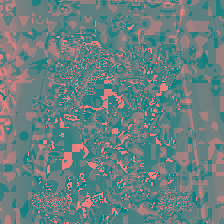

In [59]:
dataset = Dataset(X)
#                   augmentation = get_validation_augmentation()) #, preprocessing = get_preprocessing())
image = dataset[500]

np.array(image).shape
# dataset.cases, dataset.epochs
# np.unique(np.array(images[6]))
# Image.fromarray(np.array(image).astype('uint8'))
# Image.fromarray(np.transpose(np.array(image).astype('uint8')[:,0,:,:], (2,1,0)))
Image.fromarray(np.transpose(np.array(image).astype('uint8'), (2,1,0)))

## Load Model

In [60]:
densenet = torchvision.models.densenet121(pretrained=True)

In [61]:
# classifier layer output shape --> number of classes
CLASSES = 3

num_ftrs = densenet.classifier.in_features
densenet.classifier = nn.Linear(num_ftrs,CLASSES)
densenet.classifier = nn.Sequential(densenet.classifier, nn.Softmax(),)

densenet.classifier

Sequential(
  (0): Linear(in_features=1024, out_features=3, bias=True)
  (1): Softmax(dim=None)
)

In [62]:
LR = 0.0001
EPOCHS = 30
TRAIN_PATIENCE = 10

optimizer = torch.optim.Adam(densenet.parameters(), lr = LR)

In [63]:
best_model = densenet

In [64]:
!ls ./saved-models-max/

model-epoch03-loss_val0.99-acc_val0.57.pt
model-epoch04-loss_val0.99-acc_val0.59.pt
model-epoch09-loss_val0.90-acc_val0.63.pt
model-epoch09-loss_val1.00-acc_val0.55.pt
model-epoch24-loss_val1.02-acc_val0.56.pt


In [80]:
DIR = WORK_DIR + 'saved-models-max/'

# weights = os.listdir(DIR)
# weights.sort()
# # val_losses = [filename.split('-')[2].split('val')[1] for filename in weights]
# val_losses = [filename.split('-')[2].split('val')[1] for filename in weights] #[1:]]
# best_weight = val_losses.index(min(val_losses))
# # path = './saved_models/' + weights[best_weight]
# path = DIR + weights[best_weight] #+1] # '.ipynb_checkpoints' 파일이 맨 앞에 있기 때문에 index가 하나씩 밀린다.

# path = DIR+ 'model-epoch02-loss_val0.86-acc_val0.60.pt'
path = './saved-models-max/model-epoch24-loss_val1.02-acc_val0.56.pt'

# best_model = torch.load(DIR+'model-epoch00-loss_val1.08-acc_val0.46.pt')
checkpoint = torch.load(path)
best_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
accuracy = checkpoint['accuracy']
# loss = checkpoint['loss']

best_model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [81]:
path

'./saved-models-max/model-epoch24-loss_val1.02-acc_val0.56.pt'

In [82]:
test_dataset = Dataset(X)

test_loader = DataLoader(test_dataset)

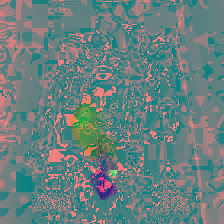

In [83]:
with open(test_dataset.imgpaths[100], 'rb') as f:
    image = np.load(f)

Image.fromarray(image).show()


In [84]:
%%time
Xtest = next(iter(test_loader))
print('Xtest:', Xtest.size(), 'type:', Xtest.type())

Xtest: torch.Size([1, 3, 224, 224]) type: torch.FloatTensor
CPU times: user 2.04 ms, sys: 0 ns, total: 2.04 ms
Wall time: 1.52 ms


In [85]:
# true_labels = []
predicted_labels = []
predicted_values = []

best_model.eval()
best_model.to(DEVICE)

# test_loss = AverageMeter()
# test_acc = AverageMeter()

with torch.no_grad():                                                     # 모델을 평가하는 단계에서는 Gradient를 통해 parameter값이 update되는 현상을 방지하기 위해 'torch.no_grad()' 메서드를 이용해 Gradient의 흐름을 억제
    for idx, image in enumerate(tqdm(test_loader)):
        image = image.to(DEVICE)
#         label = label.to(DEVICE)
        output = best_model(image)
#         loss = criterion(output, label)
        prediction = output.max(1, keepdim = True)[1]                     # output값 (prediction probability)가 가장 높은 index(class)로 예측
        
#         true_labels.append(label)
        predicted_labels.append(prediction)
        predicted_values.append(output)
        
#         test_acc.update(prediction.eq(label.view_as(prediction)).sum().item()/BATCH_SIZE)
#         test_loss.update(loss.item())
        
# test_loss.avg, test_acc.avg

100%|██████████| 32888/32888 [12:40<00:00, 43.26it/s]


In [90]:
predicted_values

[tensor([[0.3081, 0.3447, 0.3472]], device='cuda:0'),
 tensor([[0.3081, 0.3447, 0.3472]], device='cuda:0'),
 tensor([[0.3081, 0.3447, 0.3472]], device='cuda:0'),
 tensor([[0.3081, 0.3447, 0.3472]], device='cuda:0'),
 tensor([[0.3081, 0.3447, 0.3472]], device='cuda:0'),
 tensor([[0.3081, 0.3447, 0.3472]], device='cuda:0'),
 tensor([[0.3081, 0.3447, 0.3472]], device='cuda:0'),
 tensor([[0.3081, 0.3447, 0.3472]], device='cuda:0'),
 tensor([[0.3081, 0.3447, 0.3472]], device='cuda:0'),
 tensor([[0.3081, 0.3447, 0.3472]], device='cuda:0'),
 tensor([[0.3081, 0.3447, 0.3472]], device='cuda:0'),
 tensor([[0.3081, 0.3447, 0.3472]], device='cuda:0'),
 tensor([[0.3081, 0.3447, 0.3472]], device='cuda:0'),
 tensor([[0.3081, 0.3447, 0.3472]], device='cuda:0'),
 tensor([[0.3081, 0.3447, 0.3472]], device='cuda:0'),
 tensor([[0.3081, 0.3447, 0.3472]], device='cuda:0'),
 tensor([[0.3081, 0.3447, 0.3472]], device='cuda:0'),
 tensor([[0.3081, 0.3447, 0.3472]], device='cuda:0'),
 tensor([[0.3081, 0.3447, 0.

In [91]:
# predicted_labels_copy = predicted_labels
# predicted_values_copy = predicted_values

In [133]:
predicted_labels = []
for output in predicted_values:
    output = [output[0][0], output[0][1], output[0][2]]
    output[0] = output[0]-0.0405
    output[1] = output[1]-0.013
    output[2] = output[2]+0.0405
    prediction = output.index(max(output))
    predicted_labels.append(prediction)

In [134]:
predicted_labels.count(0),\
predicted_labels.count(1),\
predicted_labels.count(2)

(7635, 17493, 7760)

In [135]:
with open('predicted_labels_max_v010.npy', 'wb') as f:
    np.save(f, np.array(predicted_labels))
    
with open('predicted_values_max_v010.npy', 'wb') as f:
    np.save(f, np.array(predicted_values))

In [136]:
X.to_csv('test_csv.csv', index = False)

In [137]:
len(predicted_values)

32888